In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from math import ceil
import os
import theano.tensor as T
import scipy.stats as st
import errno

RANDOM_SEED = 28101990

In [2]:
#%load_ext autoreload
#%autoreload 2
#%load_ext lab_black
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Tue Aug 10 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 4.15.0-147-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

pandas    : 1.3.1
scipy     : 1.7.1
pymc3     : 3.11.2
numpy     : 1.21.1
theano    : 1.1.2
arviz     : 0.11.2
matplotlib: 3.4.2

Watermark: 2.2.0



In [3]:
def load_trace(model_path, url_data):
    try:
        trace=az.from_netcdf(model_path)
    except:
        print("Need to download model from OSF.")
        import urllib.request
        model_name = model_path.split("/")[-1]
        urllib.request.urlretrieve(url_data, model_name)
        trace = az.from_netcdf(model_name)
    return trace

In [4]:
def remove(filename):
    """
    Call remove of os and not give error if file does not exist.
    """
    try:
        os.remove(filename)
    except OSError as e:  # this would be "except OSError, e:" before Python 2.6
        print("Didn't remove anything")
        if e.errno != errno.ENOENT:  # errno.ENOENT = no such file or directory
            raise  # re-raise exception if a different error occurred

In [5]:
raw_data_dir = "../data/raw/"
interim_data_dir = "../data/interim/"
processed_data_dir = "../data/processed/"
external_data_dir = "../data/external/"
models_dir = "../models/"

In [6]:
model_path = models_dir + "tpore_survival_analysis_time_dep_beta_same_membrane.nc"

In [7]:
infer = False
save_data = True
print(model_path)
url_data = ("https://osf.io/yh6fw/download")

../models/tpore_survival_analysis_time_dep_beta_same_membrane.nc


# Load data

In [8]:
df = pd.read_csv(f"{processed_data_dir}data.csv").drop("Unnamed: 0", axis=1)

In [9]:
df.Replica = df.membrane

In [10]:
df.Replica = df.Replica.astype("category")

In [11]:
df["Replica_enc"] = df.Replica.cat.codes

In [12]:
category_dic = {i: cat for i, cat in enumerate(np.unique(df["Replica"]))}

In [13]:
category_dic

{0: 'APM', 1: 'APM-hyp', 2: 'BPM', 3: 'BPM-hyp'}

In [14]:
n_categories = len(category_dic)

In [15]:
dummies = pd.get_dummies(df.Replica, prefix="Replica")

In [16]:
for col in dummies.columns:
    df[col] = dummies[col]

In [17]:
df.tpore = df.tpore * 10
df.tpore = df.tpore.astype(int)

In [18]:
df.head()

,Replica,run,conf,frame,tpore,x0,y0,x1,y1,x2,y2,x3,y3,membrane,Replica_enc,Replica_APM,Replica_APM-hyp,Replica_BPM,Replica_BPM-hyp
0,APM-hyp,1,9,16,16,78,203,NaN,NaN,NaN,NaN,NaN,NaN,APM-hyp,1,0,1,0,0
1,APM-hyp,2,9,15,15,68,130,NaN,NaN,NaN,NaN,NaN,NaN,APM-hyp,1,0,1,0,0
2,APM-hyp,3,9,11,11,133,131,NaN,NaN,NaN,NaN,NaN,NaN,APM-hyp,1,0,1,0,0
3,APM-hyp,4,9,10,10,199,114,NaN,NaN,NaN,NaN,NaN,NaN,APM-hyp,1,0,1,0,0
4,APM-hyp,5,9,13,13,17,13,NaN,NaN,NaN,NaN,NaN,NaN,APM-hyp,1,0,1,0,0


## Visualize Data

In [19]:
df["tpore"].groupby(df["Replica"]).describe()

,count,mean,std,min,25%,50%,75%,max
Replica,,,,,,,,
APM,240.0,34.541667,17.195843,8.0,22.00,31.0,43.00,107.0
APM-hyp,240.0,21.220833,7.381220,7.0,16.00,20.0,25.00,44.0
BPM,240.0,65.975000,37.023449,13.0,38.75,56.0,87.25,211.0
BPM-hyp,240.0,41.920833,20.835428,8.0,26.00,37.0,50.00,123.0


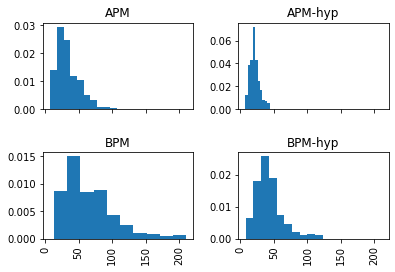

In [20]:
_ = df["tpore"].hist(by=df["Replica"], sharex=True, density=True, bins=10)

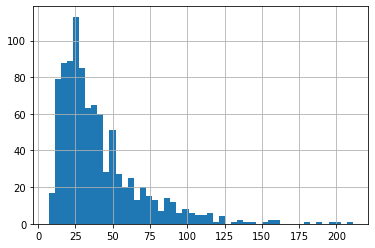

In [21]:
_ = df["tpore"].hist(bins=50)

## Visualize Priors

These are the shapes of the priors used.

Text(0.5, 0, 'lambda0(t)')

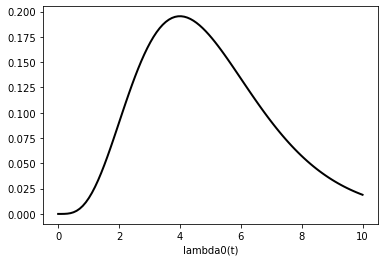

In [22]:
beta = 1
alpha = 5
d = st.gamma(scale=1 / beta, a=alpha)
x = np.linspace(0, 10, 100)
tau_0_pdf = d.pdf(x)
plt.plot(x, tau_0_pdf, "k-", lw=2)
plt.xlabel("lambda0(t)")

## Prepare data

In [23]:
n_sims = df.shape[0]
sims = np.arange(n_sims)
interval_length = 15  # 1.5 ns
interval_bounds = np.arange(0, df.tpore.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [24]:
last_period = np.floor((df.tpore - 0.01) / interval_length).astype(int)

pore = np.zeros((n_sims, n_intervals))
pore[sims, last_period] = np.ones(n_sims)

In [25]:
exposure = (
    np.greater_equal.outer(df.tpore.values, interval_bounds[:-1]) * interval_length
)
exposure[sims, last_period] = df.tpore - interval_bounds[last_period]

## Run Model

In [26]:
with pm.Model() as model:

    lambda0 = pm.Gamma("lambda0", 5, 1, shape=(1, n_intervals))

    beta = pm.GaussianRandomWalk("beta", tau=0.1, shape=(n_intervals, n_categories))

    lambda_ = pm.Deterministic(
        "lambda_",
        T.exp(T.dot(beta, T.constant(dummies).T)) * lambda0.T,
    )
    mu = pm.Deterministic("mu", lambda_.T * exposure)
    exp_beta = pm.Deterministic("exp_beta", np.exp(beta))

    obs = pm.Poisson(
        "obs",
        mu,
        observed=pore,
    )

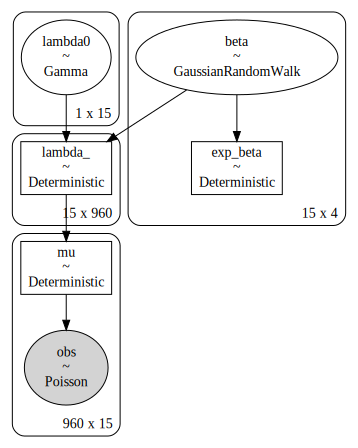

In [27]:
pm.model_to_graphviz(model)

In [28]:
%%time
if infer:
    with model:
        trace = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, return_inferencedata=True, cores=8)
else:
     trace=load_trace(model_path, url_data)

Need to download model from OSF.
CPU times: user 1.35 s, sys: 790 ms, total: 2.14 s
Wall time: 38.1 s


In [29]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [30]:
if infer:
    trace.posterior = trace.posterior.reset_index(
        [
            "beta_dim_0",
            "exp_beta_dim_0",
            "beta_dim_1",
            "exp_beta_dim_1",
            "lambda0_dim_1",
        ],
        drop=True,
    )

    trace = trace.rename(
        {
            "lambda0_dim_1": "t",
            "beta_dim_1": "Membrane",
            "exp_beta_dim_1": "Membrane",
            "beta_dim_0": "t",
            "exp_beta_dim_0": "t",
        }
    )

    trace = trace.assign_coords(
        t=interval_bounds[:-1] / 10,
        Membrane=list(category_dic.values()),
    )

## Convergences

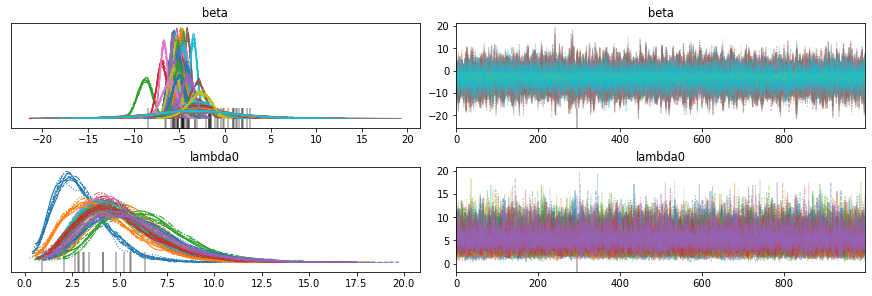

In [31]:
with az.rc_context(rc={"plot.max_subplots": None}):
    az.plot_trace(trace, var_names=["beta", "lambda0"])

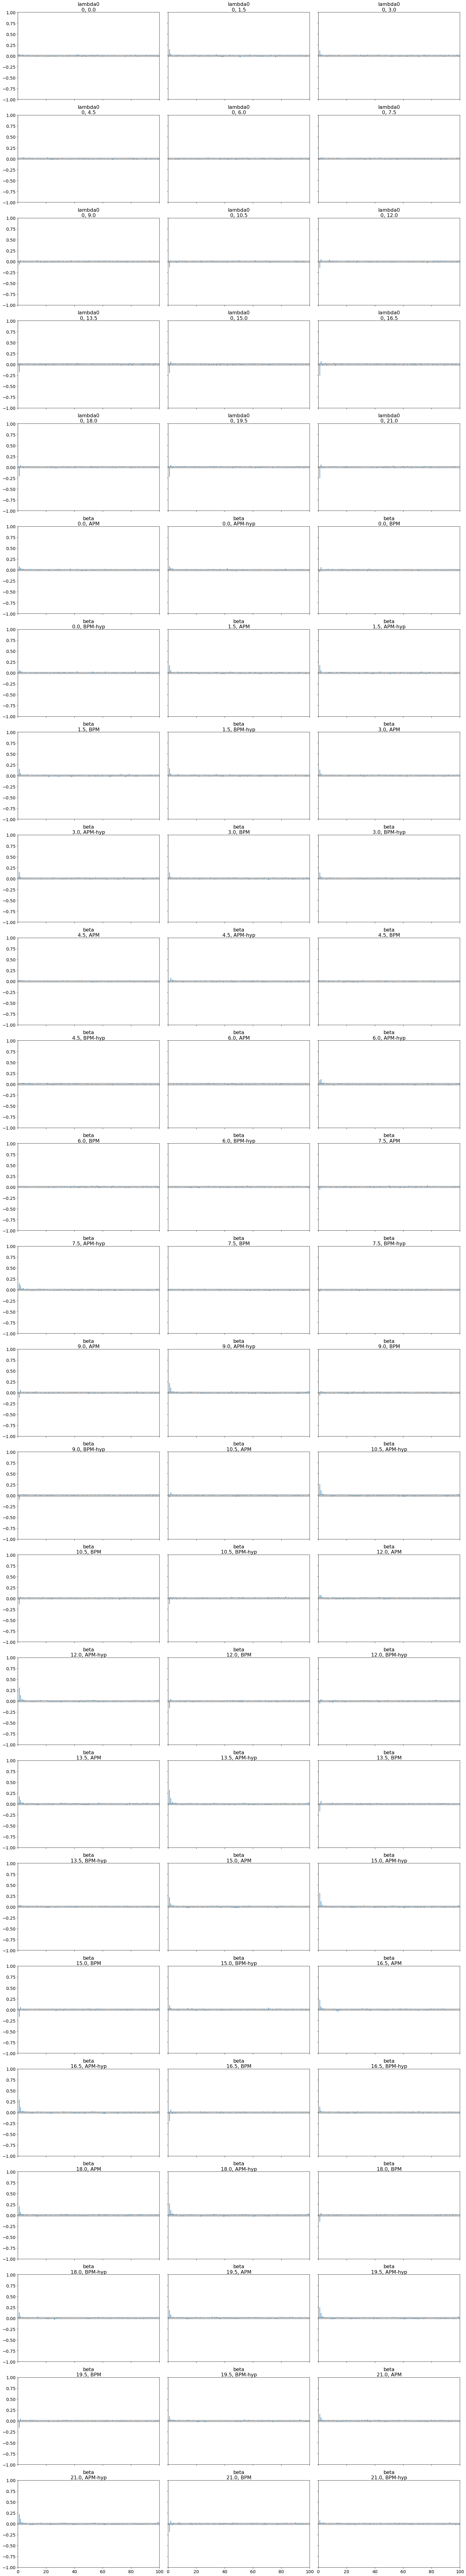

In [32]:
with az.rc_context(rc={"plot.max_subplots": None}):
    az.plot_autocorr(trace, combined=True, var_names=["lambda0", "beta"])

In [33]:
def get_survival_function(trace):
    l = []
    for interval in range(n_intervals - 1):
        l.append(
            np.trapz(
                trace.values[:, :, 0 : interval + 1, :],
                axis=2,
                dx=interval_length,
            )
        )

    l = np.exp(-np.array(l))
    return l

In [34]:
def get_ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

In [35]:
def get_hdi(x, axis, alpha=0.06):
    x_mean = np.nanmedian(x, axis=axis)
    percentiles = 100 * np.array([alpha / 2.0, 1.0 - alpha / 2.0])
    hdi = np.nanpercentile(x, percentiles, axis=axis)

    return x_mean, hdi

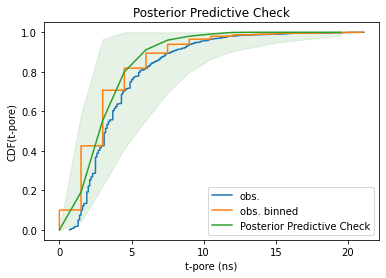

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

survival_function = get_survival_function(trace.posterior.lambda_)
# Empyrical CDF data
ax.plot(*get_ecdf(df.tpore / 10), label="obs.")

# Empyrical CDF data-binned
binned_data = np.where(pore[:, :] == 1)[1] * interval_length / 10
ax.plot(*get_ecdf(binned_data), label="obs. binned")

# Plot Posterior Predictive
hdi = get_hdi(survival_function[:, :, :, :], axis=(1, 2, 3))
x = np.arange(n_intervals - 1) * interval_length / 10.0
ax.plot(x, 1 - hdi[0], label="Posterior Predictive Check")
ax.fill_between(x, 1 - hdi[1][0, :], 1 - hdi[1][1, :], alpha=0.1, color="g")
ax.set_xlabel("t-pore (ns)")
ax.set_ylabel("CDF(t-pore)")
ax.set_title("Posterior Predictive Check")
ax.legend()

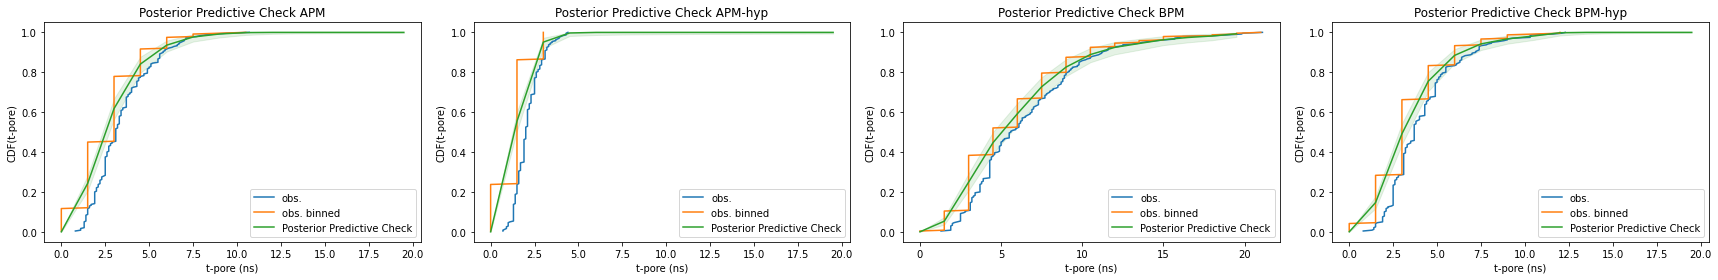

In [37]:
n_categories = len(category_dic)
n_rows = ceil(n_categories / 4)
fig, ax = plt.subplots(n_rows, 4, figsize=(6 * 4, 4 * n_rows))

ax = ax.flatten()
for i in range(n_categories):
    # Mask by replica type
    mask = df.Replica == category_dic[i]

    survival_function = get_survival_function(trace.posterior.lambda_[:, :, :, mask])
    # Empyrical CDF data
    ax[i].plot(*get_ecdf(df[mask].tpore / 10), label="obs.")

    # Empyrical CDF data-binned
    binned_data = np.where(pore[mask, :] == 1)[1] * interval_length / 10
    ax[i].plot(*get_ecdf(binned_data), label="obs. binned")

    # Plot Posterior Predictive
    hdi = get_hdi(survival_function[:, :, :, :], axis=(1, 2, 3))
    x = np.arange(n_intervals - 1) * interval_length / 10.0
    ax[i].plot(x, 1 - hdi[0], label="Posterior Predictive Check")
    ax[i].fill_between(x, 1 - hdi[1][0, :], 1 - hdi[1][1, :], alpha=0.1, color="g")
    ax[i].set_xlabel("t-pore (ns)")
    ax[i].set_ylabel("CDF(t-pore)")
    ax[i].set_title(f"Posterior Predictive Check {category_dic[i]}")
    ax[i].legend()
fig.tight_layout()

## Analyze

### Plot posterior

Text(0.5, 0, 'lambda0[t]')

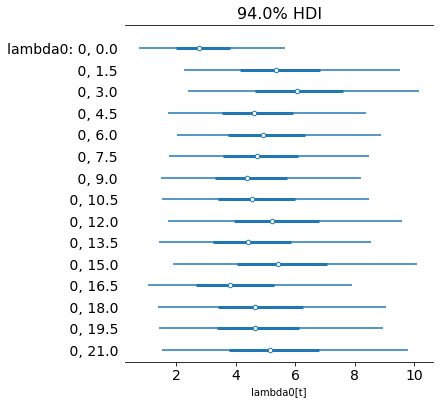

In [38]:
variable = "lambda0"
ax = az.plot_forest(trace, var_names=variable, combined=True)
ax[0].set_xlabel("lambda0[t]")

Text(0.5, 0, 'beta')

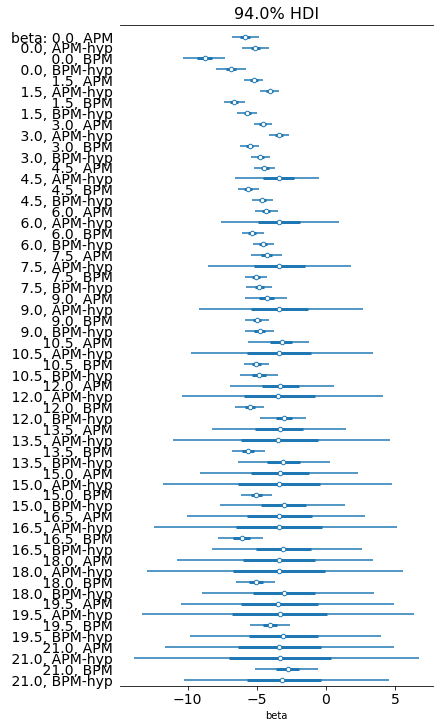

In [39]:
variable = "beta"
ax = az.plot_forest(trace, var_names=variable, combined=True)
ax[0].set_xlabel("beta")

Text(0.5, 0, 'exp(beta)')

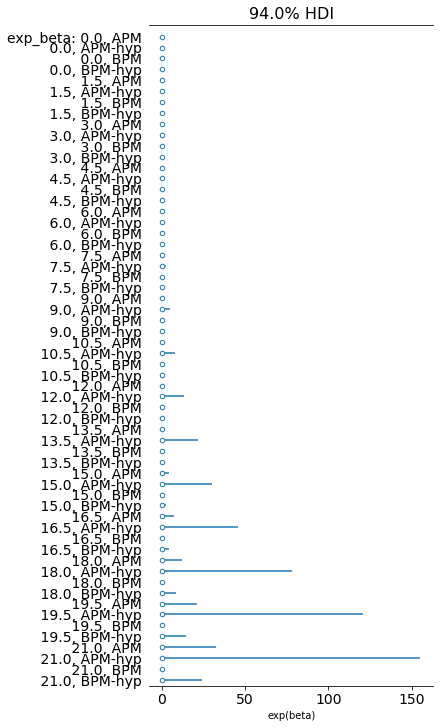

In [40]:
variable = "exp_beta"
ax = az.plot_forest(trace, var_names=variable, combined=True)
ax[0].set_xlabel("exp(beta)")

In [41]:
trace.posterior.beta.values.shape

(8, 1000, 15, 4)

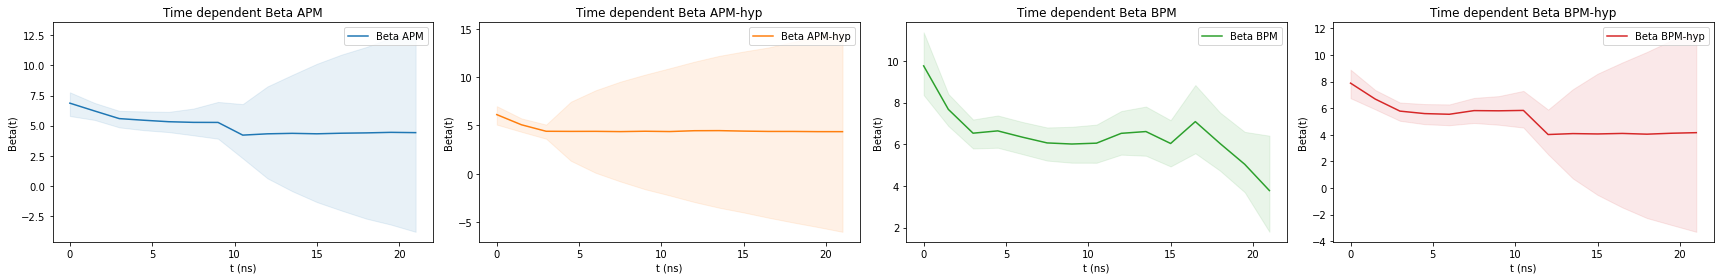

In [42]:
n_categories = len(category_dic)
n_rows = ceil(n_categories / 4)
fig, ax = plt.subplots(n_rows, 4, figsize=(6 * 4, 4 * n_rows))

ax = ax.flatten()
betas = trace.posterior.beta.values
for i in range(n_categories):
    # Mask by replica type

    hdi = get_hdi(betas[:, :, :, i], axis=(0, 1))
    x = np.arange(n_intervals) * interval_length / 10.0
    ax[i].plot(x, 1 - hdi[0], label=f"Beta {category_dic[i]}", color=f"C{i}")
    ax[i].fill_between(x, 1 - hdi[1][0, :], 1 - hdi[1][1, :], alpha=0.1, color=f"C{i}")
    ax[i].set_xlabel("t (ns)")
    ax[i].set_ylabel("Beta(t)")
    ax[i].set_title(f"Time dependent Beta {category_dic[i]}")
    ax[i].legend()
fig.tight_layout()

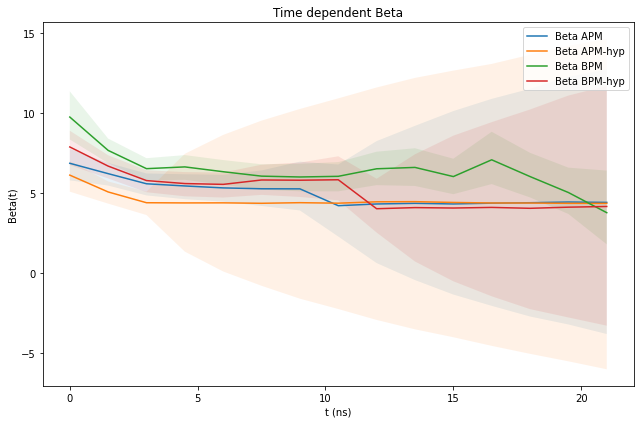

In [43]:
n_categories = len(category_dic)
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

betas = trace.posterior.beta.values
for i in range(n_categories):
    # Mask by replica type

    hdi = get_hdi(betas[:, :, :, i], axis=(0, 1))
    x = np.arange(n_intervals) * interval_length / 10.0
    ax.plot(x, 1 - hdi[0], label=f"Beta {category_dic[i]}")
    ax.fill_between(
        x,
        1 - hdi[1][0, :],
        1 - hdi[1][1, :],
        alpha=0.1,
    )
ax.set_xlabel("t (ns)")
ax.set_ylabel("Beta(t)")
ax.set_title(f"Time dependent Beta")
ax.legend()
fig.tight_layout()

(0.0, 0.4)

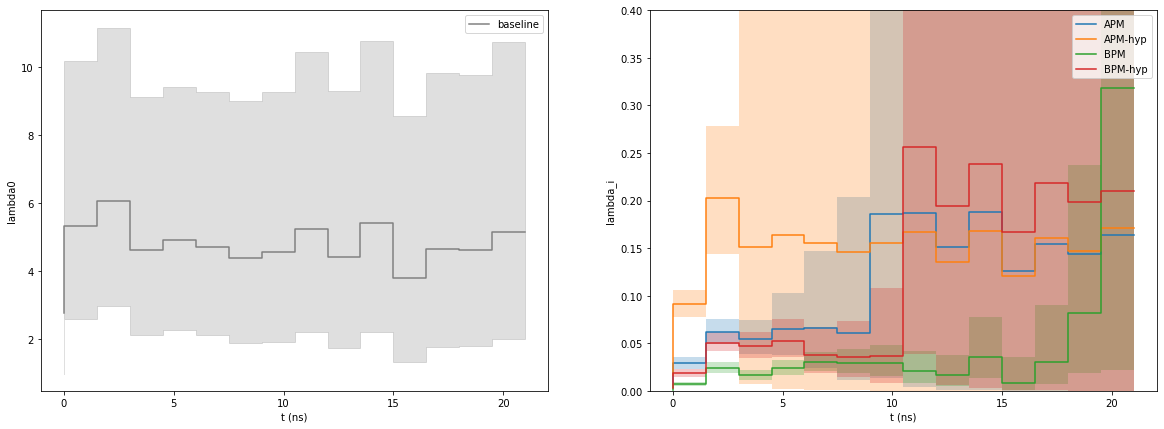

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
lambda0 = trace.posterior.lambda0.values
beta = trace.posterior.beta.values
y, hdi = get_hdi(lambda0, (0, 1, 2))
x = interval_bounds[:-1] / 10
ax[0].fill_between(x, hdi[0], hdi[1], alpha=0.25, step="pre", color="grey")
ax[0].step(x, y, label="baseline", color="grey")
for i in range(n_categories):
    lam = np.exp(beta[:, :, :, i]) * lambda0[:, :, 0, :]
    y, hdi = get_hdi(lam, (0, 1))
    ax[1].fill_between(x, hdi[0], hdi[1], alpha=0.25, step="pre")
    ax[1].step(x, y, label=f"{category_dic[i]}")

ax[0].legend(loc="best")
ax[0].set_ylabel("lambda0")
ax[0].set_xlabel("t (ns)")
ax[1].legend(loc="best")
ax[1].set_ylabel("lambda_i")
ax[1].set_xlabel("t (ns)")
ax[1].set_ylim([0, 0.4])

## Save Model?

In [45]:
print(model_path)

../models/tpore_survival_analysis_time_dep_beta_same_membrane.nc


In [46]:
if save_data:
    remove(model_path)
    trace.to_netcdf(model_path)

Didn't remove anything
